In [14]:
#-------------------------Setting the randomness-----------#

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2,3,4"  # specify which GPU(s) to be used


import numpy as np
np.random.seed(1) # for reproducability

from tensorflow import set_random_seed
set_random_seed(1) # for reproducability
#------------------------------------------------------#
import keras
from keras.models import Sequential
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.core import Dense, Dropout, Flatten, Activation,Reshape

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split



In [5]:
from numpy import load
train_data = load('data/training_data.npy')
test_data = load('data/testing_data.npy')


In [6]:
def balanced(option):
    if(option=="yes"):
        training_data = np.concatenate((train_data[0:1341],train_data[3875:]),axis=0)
        testing_data = np.concatenate((test_data[0:234],test_data[390:]))
        return training_data,testing_data
    else:
        training_data = train_data
        testing_data = test_data
        return training_data,testing_data


In [7]:
training_data,test_data=balanced("no")
print(training_data.shape)
print(test_data.shape)



(5216, 62501)
(624, 62501)


In [8]:
X_train,X_val,Y_train,Y_val = train_test_split(training_data[0:,1:],training_data[0:,0:1],test_size=0.1,random_state = 1,shuffle=True,stratify=training_data[0:,0:1])

In [9]:
print('All (class distribution):', np.bincount(list(map(float, training_data[0:,0:1]))) / float(len(training_data)) * 100.0)
print('Training (class distribution):', np.bincount(list(map(float,Y_train))) / float(len(Y_train)) * 100.0)
print('Validation (class distribution):', np.bincount(list(map(float,Y_val))) / float(len(Y_val)) * 100.0)

All (class distribution): [25.70935583 74.29064417]
Training (class distribution): [25.71367703 74.28632297]
Validation (class distribution): [25.67049808 74.32950192]


In [10]:
X_test = test_data[0:,1:]
Y_test = test_data[0:,0:1]

In [11]:
y_train_ohe = keras.utils.to_categorical(Y_train, 2)
y_test_ohe = keras.utils.to_categorical(Y_test, 2)
y_val_ohe = keras.utils.to_categorical(Y_val,2)

In [12]:
X_train = X_train.reshape(X_train.shape[0],250,250,1)
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0],250,250,1)
print(X_test.shape)
X_val = X_val.reshape(X_val.shape[0],250,250,1)
print(X_val.shape)

(4694, 250, 250, 1)
(624, 250, 250, 1)
(522, 250, 250, 1)


In [13]:
def create_model():
    model_CNN = Sequential()
    
    model_CNN.add(Conv2D(32,(3,3),input_shape=(250,250,1)))
    model_CNN.add(Activation('relu')) # Remember, Batch Norm is meant to go before activation. However, for purposes of recreating experriment 1 keep Batch Norm after activation
    model_CNN.add(MaxPooling2D(pool_size=(2,2)))
    
    model_CNN.add(Conv2D(64, (3, 3)))
    model_CNN.add(Activation('relu'))
    model_CNN.add(MaxPooling2D(pool_size=(2,2)))
    
    model_CNN.add(Conv2D(128, (3, 3)))
    model_CNN.add(Activation('relu'))
    model_CNN.add(MaxPooling2D(pool_size=(2,2)))
    
    model_CNN.add(Flatten())

    # Fully connected layer
    model_CNN.add(Dense(128))
    model_CNN.add(Activation('relu'))

    model_CNN.add(Dropout(0.1))
    
    model_CNN.add(Dense(64))
    model_CNN.add(Activation('relu'))

    

    model_CNN.add(Dense(2))
    model_CNN.add(Activation('softmax'))
    
    return model_CNN

In [15]:
history_array = [] ## Used to get callbacks for 10 models
accuracy = [] ## Compute the accuracy from 10 models
model_array = [] # Save 10 models to array to be used for computing the test and returning predictions which are for printing confusion matrix
for i in range(0,5):
    model = create_model()  
    opt = optimizers.Adam(lr=0.0001)
    model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
    np.random.seed(1) # for reproducability
    #shuffle= false needs to be used if you want results to be the same every time
    history = model.fit(X_train, y_train_ohe,shuffle=True,batch_size=64,epochs=20,validation_data=(X_val, y_val_ohe))# model
    model_array.append(model)
    history_array.append(history)
    score = model.evaluate(X_test, y_test_ohe)
    accuracy.append(score)

W0424 11:51:49.088858 140519366989632 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1633: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0424 11:51:49.106100 140519366989632 module_wrapper.py:136] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0424 11:51:49.578153 140519366989632 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:550: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Train on 4694 samples, validate on 522 samples
Epoch 1/20
4694/4694 [==============================] - 8s 2ms/step - loss: 0.4692 - accuracy: 0.7727 - val_loss: 0.2869 - val_accuracy: 0.8966
Epoch 2/20
4694/4694 [==============================] - 6s 1ms/step - loss: 0.1719 - accuracy: 0.9340 - val_loss: 0.1112 - val_accuracy: 0.9598
Epoch 3/20
4694/4694 [==============================] - 6s 1ms/step - loss: 0.1063 - accuracy: 0.9612 - val_loss: 0.0845 - val_accuracy: 0.9732
Epoch 4/20
4694/4694 [==============================] - 6s 1ms/step - loss: 0.0928 - accuracy: 0.9636 - val_loss: 0.0686 - val_accuracy: 0.9693
Epoch 5/20
4694/4694 [==============================] - 6s 1ms/step - loss: 0.0799 - accuracy: 0.9708 - val_loss: 0.0652 - val_accuracy: 0.9693
Epoch 6/20
4694/4694 [==============================] - 6s 1ms/step - loss: 0.0844 - accuracy: 0.9674 - val_loss: 0.0779 - val_accuracy: 0.9674
Epoch 7/20
4694/4694 [==============================] - 6s 1ms/step - loss: 0.0648 - accu

Epoch 16/20
4694/4694 [==============================] - 6s 1ms/step - loss: 0.0239 - accuracy: 0.9928 - val_loss: 0.0428 - val_accuracy: 0.9847
Epoch 17/20
4694/4694 [==============================] - 6s 1ms/step - loss: 0.0289 - accuracy: 0.9898 - val_loss: 0.0498 - val_accuracy: 0.9866
Epoch 18/20
4694/4694 [==============================] - 6s 1ms/step - loss: 0.0301 - accuracy: 0.9881 - val_loss: 0.0491 - val_accuracy: 0.9847
Epoch 19/20
4694/4694 [==============================] - 6s 1ms/step - loss: 0.0200 - accuracy: 0.9936 - val_loss: 0.0467 - val_accuracy: 0.9770
Epoch 20/20
624/624 [==============================] - 0s 572us/step
Train on 4694 samples, validate on 522 samples
Epoch 1/20
4694/4694 [==============================] - 6s 1ms/step - loss: 0.3783 - accuracy: 0.8317 - val_loss: 0.1942 - val_accuracy: 0.9215
Epoch 2/20
4694/4694 [==============================] - 6s 1ms/step - loss: 0.1369 - accuracy: 0.9484 - val_loss: 0.0875 - val_accuracy: 0.9751
Epoch 3/20
4694/

In [16]:
#print out accuracies for 5 models
print(accuracy)

[[1.2988535835111412, 0.7676281929016113], [1.481238927085472, 0.7612179517745972], [1.5861166322149354, 0.75], [1.5947289292675215, 0.7467948794364929], [1.4481452972650937, 0.7612179517745972]]


[0.77268857, 0.93395823, 0.9612271, 0.96357054, 0.9708138, 0.9674052, 0.97763103, 0.9812527, 0.97848314, 0.98189175, 0.9816787, 0.9846613, 0.98317003, 0.98508734, 0.9870047, 0.988709, 0.9891351, 0.9857265, 0.99296975, 0.9916915]
[0.8965517282485962, 0.959770143032074, 0.9731800556182861, 0.969348669052124, 0.969348669052124, 0.967432975769043, 0.977011501789093, 0.9808428883552551, 0.9808428883552551, 0.9731800556182861, 0.9731800556182861, 0.9865900278091431, 0.982758641242981, 0.975095808506012, 0.984674334526062, 0.9808428883552551, 0.9865900278091431, 0.9789271950721741, 0.969348669052124, 0.982758641242981]


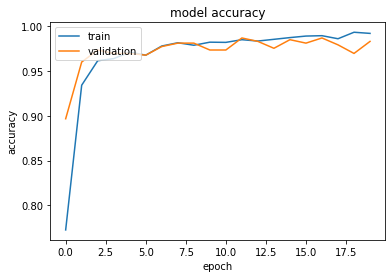

[0.81678736, 0.9420537, 0.9620792, 0.96357054, 0.9671922, 0.97102684, 0.9750746, 0.9782701, 0.9808266, 0.98317003, 0.9835961, 0.98231786, 0.98444825, 0.9861525, 0.9825309, 0.9891351, 0.9893481, 0.9880699, 0.9914785, 0.9925437]
[0.9214559197425842, 0.977011501789093, 0.9789271950721741, 0.9789271950721741, 0.9808428883552551, 0.969348669052124, 0.967432975769043, 0.984674334526062, 0.9808428883552551, 0.9789271950721741, 0.975095808506012, 0.9885057210922241, 0.984674334526062, 0.982758641242981, 0.984674334526062, 0.984674334526062, 0.9865900278091431, 0.984674334526062, 0.961685836315155, 0.9865900278091431]


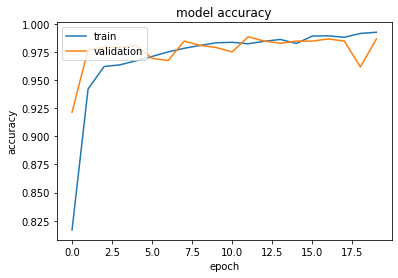

[0.8317, 0.9471666, 0.96548784, 0.96271837, 0.96804434, 0.97550064, 0.97550064, 0.98103964, 0.98338306, 0.9846613, 0.98508734, 0.9857265, 0.98338306, 0.9902003, 0.9865786, 0.9927567, 0.98977417, 0.9880699, 0.9936089, 0.99531317]
[0.9176245331764221, 0.9731800556182861, 0.9808428883552551, 0.9789271950721741, 0.9789271950721741, 0.969348669052124, 0.9789271950721741, 0.982758641242981, 0.982758641242981, 0.9789271950721741, 0.975095808506012, 0.9865900278091431, 0.984674334526062, 0.977011501789093, 0.984674334526062, 0.984674334526062, 0.9865900278091431, 0.984674334526062, 0.977011501789093, 0.9865900278091431]


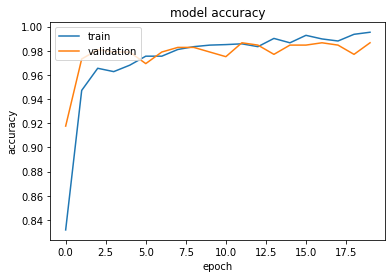

[0.8317, 0.94844484, 0.9650618, 0.96357054, 0.96634, 0.9742224, 0.97550064, 0.9814657, 0.98338306, 0.98444825, 0.98551345, 0.98444825, 0.98423517, 0.98977417, 0.9865786, 0.9910524, 0.9910524, 0.988709, 0.994461, 0.99531317]
[0.9214559197425842, 0.975095808506012, 0.9789271950721741, 0.977011501789093, 0.977011501789093, 0.967432975769043, 0.9789271950721741, 0.984674334526062, 0.984674334526062, 0.9808428883552551, 0.975095808506012, 0.9885057210922241, 0.984674334526062, 0.9808428883552551, 0.982758641242981, 0.984674334526062, 0.9885057210922241, 0.984674334526062, 0.9789271950721741, 0.9865900278091431]


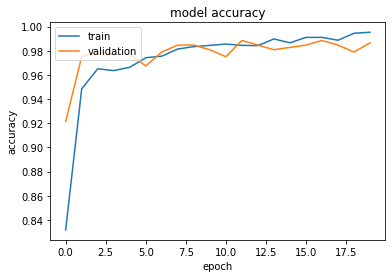

[0.81700045, 0.9414146, 0.96442264, 0.9629314, 0.96825737, 0.9714529, 0.9759267, 0.97848314, 0.9808266, 0.9838091, 0.9838091, 0.9825309, 0.98338306, 0.9870047, 0.98743075, 0.988709, 0.988709, 0.98956114, 0.99083936, 0.99190456]
[0.9214559197425842, 0.977011501789093, 0.9808428883552551, 0.9789271950721741, 0.9808428883552551, 0.9636015295982361, 0.9789271950721741, 0.982758641242981, 0.984674334526062, 0.9789271950721741, 0.975095808506012, 0.9865900278091431, 0.984674334526062, 0.982758641242981, 0.9808428883552551, 0.982758641242981, 0.9865900278091431, 0.984674334526062, 0.9655172228813171, 0.9865900278091431]


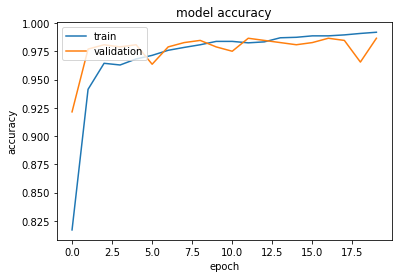

In [18]:

import matplotlib.pyplot as plt
count = 0; 


for i in history_array:
    print(i.history['accuracy'])
    plt.plot(i.history['accuracy'])
    print(i.history['val_accuracy'])
    plt.plot(i.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','validation'],loc='upper left')
    name = 'train_vs_validation_accuracy' + str(count) + '.png'
    #plt.savefig('experiment2/'+name)
    plt.show()



[0.38480864089374395, 0.14283726893565377, 0.10002061514271972, 0.08594667781374533, 0.07526497377466028, 0.07521580744568063, 0.0602429088873334, 0.052228363764936184, 0.05186698151634102, 0.050300717297374, 0.04632337242809315, 0.037651329961596244, 0.049691761586327834, 0.037044783831150625, 0.03311570773724963, 0.02727391748261746, 0.030520674766608386, 0.028171729575802936, 0.02238063668831389, 0.02131692643442422]
[0.23080185706588044, 0.10269013989245755, 0.09702067242728339, 0.06591521359095172, 0.061466966345335335, 0.05969575545625668, 0.055131493129150166, 0.05767644116819133, 0.05178675943293334, 0.05670777339688092, 0.087991906137302, 0.04690220069953765, 0.07832089743052406, 0.05973465790636695, 0.05211903441740179, 0.052622933782836945, 0.04729753258099273, 0.05370823461990589, 0.07883336230170453, 0.05486822483697157]


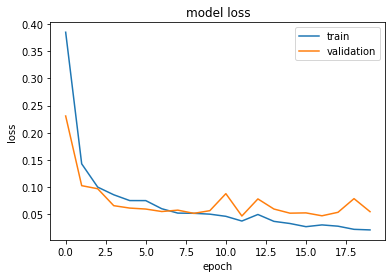

[0.41445336097547436, 0.16404474237445674, 0.10684471339000048, 0.09449456694357741, 0.08036762848655163, 0.08404280604024009, 0.06291139801598301, 0.06146610316808141, 0.06151810223073986, 0.05043831940035605, 0.05000867831993342, 0.04268056151632126, 0.048903244037639855, 0.03884486596147253, 0.03882560968989507, 0.03209174821541367, 0.030362531559444204, 0.03170496976684777, 0.028223234009351637, 0.029164013375548394]
[0.2565011243938943, 0.09846439389547626, 0.0801652286244535, 0.062275545400392505, 0.05842438625649931, 0.05319794871169945, 0.05513753763389313, 0.05260055162497864, 0.057604534101897274, 0.04660473970189633, 0.06224404215470128, 0.045467800789038115, 0.05980362237870008, 0.05280655008737155, 0.05108230717308905, 0.0423471022226002, 0.03633029118779747, 0.05113240337120619, 0.04453625973185588, 0.05135563041629462]


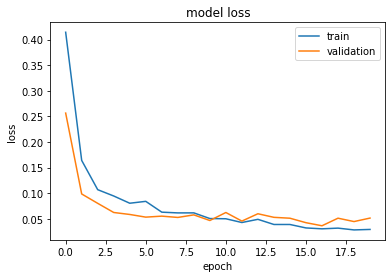

[0.41431182853379145, 0.16416998226616197, 0.10719537645622827, 0.09419726072776861, 0.08037656309772767, 0.08477300002855104, 0.06382253983990152, 0.06271301459125829, 0.06022721169612473, 0.05085937911823144, 0.052547630968630236, 0.04273655013037226, 0.04810353227413661, 0.039229302674620825, 0.03995623466017897, 0.031307733463362325, 0.03169805853273267, 0.03147037230546316, 0.027872086501421194, 0.027639412740582753]
[0.2579372392760383, 0.0989250416842457, 0.07961255491807542, 0.06221545294954859, 0.05905345349904449, 0.05311875235132331, 0.05390656657402771, 0.05139243154575998, 0.05609983043081459, 0.04539661593307024, 0.06160173071298563, 0.04467137438027452, 0.05836036690007681, 0.056255967395515735, 0.0508213147121371, 0.04447815802761878, 0.037956404824423605, 0.04833584841183776, 0.04634616169293493, 0.05829374409384198]


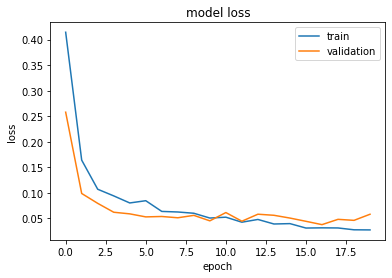

[0.41429224399541054, 0.16410719116647343, 0.10698776733896861, 0.09443550428330365, 0.08006656911457453, 0.08463635604430195, 0.06320165679760319, 0.061444056922316706, 0.06021984197591397, 0.05133111296522399, 0.0527878515755668, 0.04319326192756435, 0.048810093950529425, 0.039526225972807964, 0.04038589746934534, 0.03247949282920863, 0.031315476111797864, 0.03342168156611549, 0.027198689992523315, 0.029864216047570485]
[0.2576240376494397, 0.09876235303294156, 0.07955038928608785, 0.06221300239364306, 0.05822453457305486, 0.053707823649733914, 0.053121820634580666, 0.05049330165959409, 0.05481621841418332, 0.04488327386307305, 0.05942138532797495, 0.04510535690505272, 0.05596170994057052, 0.050661740403522476, 0.049316070203123424, 0.04204936708783966, 0.03616520816681486, 0.05202965527573079, 0.045525277982612224, 0.054992460028421834]


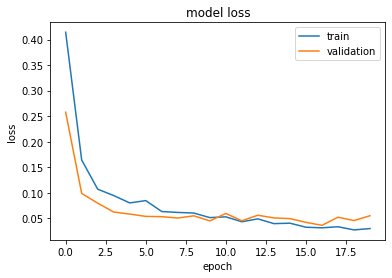

[0.41420493953320436, 0.16410670691365428, 0.10685438223097443, 0.09416625995076257, 0.0800353171193554, 0.0834676734587272, 0.06290242401307626, 0.06137458123917472, 0.060768595509767584, 0.0512826407870296, 0.0527550986954886, 0.042985948142335674, 0.04796513707925017, 0.03979330627834182, 0.03874772601385141, 0.032964852715127765, 0.03224979892919101, 0.0331214437222336, 0.026905880940178886, 0.026206662056096213]
[0.25816308972479285, 0.09879910263636103, 0.079002662651041, 0.06267994631552833, 0.05798957169312855, 0.05331093230609465, 0.053578024515989184, 0.05091802150696174, 0.05585874874016334, 0.04567783481487826, 0.05494866323197025, 0.042822581708745255, 0.057043730184949674, 0.05231648684975288, 0.04660333014339551, 0.04263340382768962, 0.03684753026827542, 0.04633060116249483, 0.04172331755588338, 0.05327572211109359]


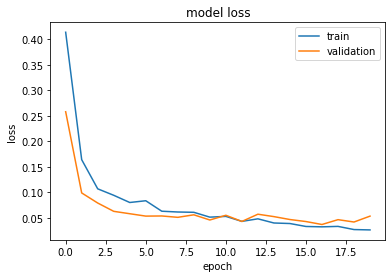

In [17]:
# summarize history for loss

count = 0 
for i in history_array:
    print(i.history['loss'])
    plt.plot(i.history['loss'])
    plt.plot(i.history['val_loss'])
    print(i.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    name = 'train_vs_test_loss_shuffled_btch32_' + str(count) + '.png'
    #plt.savefig(name)
    count = count +1
    plt.show()    
    
  

In [19]:
from sklearn.metrics import confusion_matrix
def classification_report():
    
    for i in model_array:
        y_pred = i.predict_classes(X_test)
        matrix = ["TN","FP"],["FN","TP"]
        print(matrix[0])
        print(matrix[1])

        ##Lets Visualise the output
        conf=confusion_matrix(Y_test, y_pred)
        print("Confusion Matrix")
        print(conf)
        # or we can use a heatmap from the seaborn library
        #import seaborn as sn
        #df_cm = pandas.DataFrame(conf, range(2), range(2))
        #sn.set(font_scale=1.4)#for label size
        #sn.heatmap(df_cm, cmap="YlGnBu", annot=True, annot_kws={"size": 20},fmt="d")# font size

        from sklearn.metrics import classification_report
        print(classification_report(Y_test,y_pred));
        



In [20]:
accuracy

[[1.2988535835111412, 0.7676281929016113],
 [1.481238927085472, 0.7612179517745972],
 [1.5861166322149354, 0.75],
 [1.5947289292675215, 0.7467948794364929],
 [1.4481452972650937, 0.7612179517745972]]

In [21]:
classification_report()

['TN', 'FP']
['FN', 'TP']
Confusion Matrix
[[ 91 143]
 [  2 388]]
              precision    recall  f1-score   support

         0.0       0.98      0.39      0.56       234
         1.0       0.73      0.99      0.84       390

    accuracy                           0.77       624
   macro avg       0.85      0.69      0.70       624
weighted avg       0.82      0.77      0.74       624

['TN', 'FP']
['FN', 'TP']
Confusion Matrix
[[ 88 146]
 [  3 387]]
              precision    recall  f1-score   support

         0.0       0.97      0.38      0.54       234
         1.0       0.73      0.99      0.84       390

    accuracy                           0.76       624
   macro avg       0.85      0.68      0.69       624
weighted avg       0.82      0.76      0.73       624

['TN', 'FP']
['FN', 'TP']
Confusion Matrix
[[ 82 152]
 [  4 386]]
              precision    recall  f1-score   support

         0.0       0.95      0.35      0.51       234
         1.0       0.72      0.99      